In [12]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/dataiku/dss/code-envs/python/Gerda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Polygon']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [13]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu

In [14]:
import geopandas as gpd
import requests
import json
from pandas.io.json import json_normalize
from itertools import islice
from shapely.geometry import Polygon, LineString
import matplotlib.pyplot as plt

In [15]:
# This function returns the fields (columns) of a given data layer number
def layer_fields(layer_number):
    layer = 'https://gisservices.noord-holland.nl/ags/rest/services/extern/pnh_areaal/MapServer/' + str(layer_number)
    query = layer +'?f=pjson'
    r = requests.get(query)
    info = json_normalize(json.loads(r.content))
    info = json_normalize(info.fields[0])
    return info

In [16]:
# This function returns all objectIDs of a given data layer number within an envelope
##### It seems that the envelope is ignored, every envelope gives the same amount of objectIDs. Find out why! 
def layer_objectIDs(layer_number, envelope):
    layer = 'https://gisservices.noord-holland.nl/ags/rest/services/extern/pnh_areaal/MapServer/' + str(layer_number)
    query = layer +'/query?where=&text=&objectIds=&time=&geometry='+ envelope + '&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=&returnGeometry=false&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=&having=&returnIdsOnly=true&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&historicMoment=&returnDistinctValues=false&resultOffset=&resultRecordCount=&queryByDistance=&returnExtentOnly=false&datumTransformation=&parameterValues=&rangeValues=&quantizationParameters=&f=pjson'
    r =  requests.get(query, verify=False)
    df = json_normalize(json.loads(r.content))
    objectIDs= df.objectIds[0]
    return objectIDs

In [17]:
# This function returns the data of the given fields of a given layer number, for the given objectIDs
def layer_data(layer_number, fields, objectIDs):
    fieldsstring = ''
    for f in range(0,len(fields)):
        field = fields[f]
        if fieldsstring == '':
            fieldsstring = field
        else:
            fieldsstring = fieldsstring + '%2C+' + field
    layer = 'https://gisservices.noord-holland.nl/ags/rest/services/extern/pnh_areaal/MapServer/' + str(layer_number)
    #query =layer+'/query?where=&text=&objectIds='+ objectIDs +'&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields='+ fieldsstring + '&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=&having=&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&historicMoment=&returnDistinctValues=false&resultOffset=&resultRecordCount=&queryByDistance=&returnExtentOnly=false&datumTransformation=&parameterValues=&rangeValues=&quantizationParameters=&f=pjson'
    query =layer+'/query?where=&text=&objectIds='+ objectIDs +'&time=&geometry=&geometryType=&inSR=&spatialRel=&relationParam=&outFields='+ fieldsstring + '&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=&having=&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&historicMoment=&returnDistinctValues=false&resultOffset=&resultRecordCount=&queryByDistance=&returnExtentOnly=false&datumTransformation=&parameterValues=&rangeValues=&quantizationParameters=&f=pjson'
   
    r =  requests.get(query, verify=False)
    df = json_normalize(json.loads(r.content))
    df = json_normalize(df.features[0])
    return df

In [18]:
# This function divides the objectIDs in chunks
def chunk(objectIDs, size):
    objectIDs = iter(objectIDs)
    objectIDs_chunks = list(iter(lambda: tuple(islice(objectIDs, size)), ()))
    return objectIDs_chunks

In [21]:
layer_number = 111 # wegvak_v
#number = 5 # Gemeentegrenzen
#number = 112 # Wegdeel_v
#layer_number = 52 # ecopassage
all_fields = layer_fields(layer_number)
fields = all_fields['name']

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [10]:
fields

NameError: name 'fields' is not defined

In [11]:
xmin = 94297.0340000019
xmax = 148229.3149
ymin = 465598.8116
ymax = 563639.916299999
envelope = str(xmin) + '%2C+' + str(ymin) + '%2C+' + str(xmax) + '%2C+' + str(ymax)
objectIDs = layer_objectIDs(layer_number, envelope)


/home/dataiku/dss/code-envs/python/Gerda/lib/python3.6/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gisservices.noord-holland.nl'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [12]:
envelope

'94297.0340000019%2C+465598.8116%2C+148229.3149%2C+563639.916299999'

In [13]:
len(objectIDs)

6475

In [14]:
n = 100 # grootte van chunks
objectIDs_chunks = list(chunk(objectIDs, n))

In [15]:
number_chunks = len(objectIDs_chunks)
number_chunks

65

In [16]:
# Areaaldata downloaden per chunk
df = pd.DataFrame()
for i in range(0,number_chunks):
    chunk = objectIDs_chunks[i]
    objectIDs_chunk = ''
    for j in range(0,len(chunk)):
        objectID = str(chunk[j])
        if objectIDs_chunk == '':
            objectIDs_chunk = objectID
        else:
            objectIDs_chunk= objectIDs_chunk + '%2C+' + objectID
    data = layer_data(layer_number, fields, objectIDs_chunk)
    df = df.append(data)

/home/dataiku/dss/code-envs/python/Gerda/lib/python3.6/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gisservices.noord-holland.nl'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/dataiku/dss/code-envs/python/Gerda/lib/python3.6/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gisservices.noord-holland.nl'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/dataiku/dss/code-envs/python/Gerda/lib/python3.6/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gisservices.noord-holland.nl'. Adding certificate verification is strongly advised. See: https://urllib

/home/dataiku/dss/code-envs/python/Gerda/lib/python3.6/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gisservices.noord-holland.nl'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/dataiku/dss/code-envs/python/Gerda/lib/python3.6/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gisservices.noord-holland.nl'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/dataiku/dss/code-envs/python/Gerda/lib/python3.6/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gisservices.noord-holland.nl'. Adding certificate verification is strongly advised. See: https://urllib

/home/dataiku/dss/code-envs/python/Gerda/lib/python3.6/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gisservices.noord-holland.nl'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/dataiku/dss/code-envs/python/Gerda/lib/python3.6/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gisservices.noord-holland.nl'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/dataiku/dss/code-envs/python/Gerda/lib/python3.6/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gisservices.noord-holland.nl'. Adding certificate verification is strongly advised. See: https://urllib

In [17]:
df

,attributes.AD_ID,attributes.NUMMER,attributes.OBJECTBEGINTIJD,attributes.OBJECTEINDTIJD,attributes.OBJECTID,attributes.OMTREK,attributes.OPMERKING,attributes.OPPERVLAKTE,attributes.SHAPE.AREA,attributes.SHAPE.LEN,attributes.TRAJECT,attributes.VERWERKINGSSTATUS,geometry.rings
0,AD.F149B5177F5E46BA8A7E2CBE13EF6CA4,63.0,1397174400000,None,41,316.000533,None,5800.013270,5800.013270,316.000533,N207b,Actueel,"[[[101184.9140000008, 475234.41789999977], [10..."
1,AD.E06348A2B8584A409FD0D54DBE899719,66.0,1397174400000,None,337,315.999646,None,5799.990150,5799.990150,315.999646,N207b,Actueel,"[[[100960.9226000011, 475433.91699999943], [10..."
2,AD.64129D820F064AAA87F5CDB2C6E6E396,76.0,1397174400000,None,338,316.000435,None,5800.020749,5800.020749,316.000435,N207b,Actueel,"[[[100270.97080000117, 476012.4585000016], [10..."
3,AD.14143EC0E57F446AB821419F50223C3A,155.0,1397174400000,None,637,319.999831,None,5999.990375,5999.990375,319.999831,N205c,Actueel,"[[[101498.65799999982, 477480.78379999846], [1..."
4,AD.0A11A2FE4225487EAE3CAA08E42AF2C7,44.0,1397174400000,None,657,315.999826,None,5800.000146,5800.000146,315.999826,N207b,Actueel,"[[[102626.4188000001, 473992.1449000016], [102..."
5,AD.D7AD566E0FD44052882FD98388882EFE,26.0,1397174400000,None,796,279.726257,None,3994.530242,3994.530242,279.726257,HOV2,Actueel,"[[[103257.88450000063, 476633.0196999982], [10..."
6,AD.49F16D049A0A41509470E258A3791A24,22.0,1397174400000,None,1045,317.273812,None,5854.003827,5854.003827,317.273812,N207b,Actueel,"[[[104441.13439999893, 473016.7153000012], [10..."
7,AD.6CF8792F7FA14242904FB2DF33320CFD,24.0,1397174400000,None,1079,279.756670,None,3995.135091,3995.135091,279.756670,HOV2,Actueel,"[[[103137.70419999957, 476498.84479999915], [1..."
8,AD.EBB62474CCBE4F47845761A065F7D252,54.0,1397174400000,None,1131,319.999718,None,6000.007344,6000.007344,319.999718,N208a,Actueel,"[[[103414.75869999826, 490647.5452999994], [10..."
9,AD.E6DD0552D4F047D2A3FA8296F6BD5CF1,148.0,1397174400000,None,1246,320.003178,None,6000.064910,6000.064910,320.003178,N205c,Actueel,"[[[102362.65199999884, 478452.0544999987], [10..."


In [18]:
df['attributes.TRAJECT'].unique()

array(['N207b', 'N205c', 'HOV2', 'N208a', 'N200a', 'N201a', 'N513a',
       'N208b', 'HOV1', 'N206b', 'N207a', 'N510b', 'N206a', 'N520b',
       'N197a', 'HOVVelsen', 'N511a', 'N512a', 'N202a', 'N205a', 'N203c',
       'N502a', 'N246a', 'N205b', 'N232b', 'N502c', 'N520a', 'N502b',
       'N196b', 'N245b', 'N244a', 'N504a', 'N203b', 'N196a', 'N201b',
       'HOV3', 'N245a', 'N248a', 'N231a', 'N510a', 'N249a', 'N242a',
       'N203a', 'N248b', 'K04/K05/K06_1', 'N514a', 'N244b', 'N232d',
       'N250a', 'N515a', 'N508a', 'N501a', 'N243a', 'N231b', 'N508b',
       'N242b_2', 'N241a', 'N516a', 'N232c', 'N521a', 'N515b', 'N194a',
       'N509a', 'N242b_1', 'N241b', 'N235a', 'N247a', 'N522a', 'N239a',
       'N240a', 'N244c', 'N247b', 'N240b', 'N239b', 'N523b', 'N236a',
       'N201c', 'N518a', 'N403a', 'N517a', 'N307_1', 'N506a', 'N240c',
       'N523a', 'N505a', 'N307_2', 'N525a', 'N527a', 'N415a', 'N417a',
       'N526a', 'N307_4', 'N307_3', 'N232a', 'N519a'], dtype=object)

In [19]:
# Stukje code van Sam om geometry te kunnen lezen.
# dit moet anders en mooier kunnen maar het werkt
def converter(row):
    # row index 0 want list is nested
    geopoints = [tuple(coords) for coords in row[0]]
    return geopoints

In [20]:
df['geometry.rings'] = df['geometry.rings'].astype(str)
#df['geometry.paths'] = df['geometry.paths'].astype(str)

In [21]:
# data is in string format -> eerst omzetten naar nested list dmv json.loads
df['geometry'] = df['geometry.rings'].apply(lambda x: Polygon(converter(json.loads(x))))
#df['geometry'] = df['geometry.paths'].apply(lambda x: Polygon(converter(json.loads(x))))

In [22]:
gdf = gpd.GeoDataFrame(df, crs='epsg:28992', geometry = 'geometry')

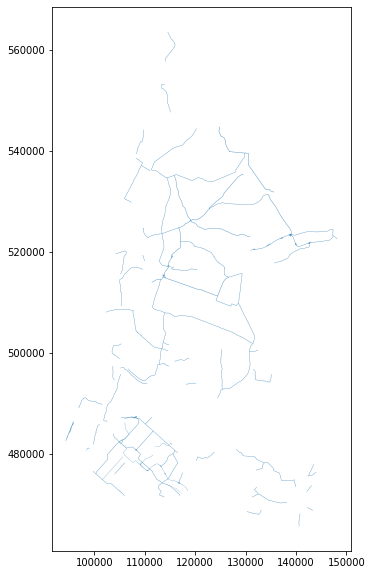

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))
gdf.plot(ax=ax)

In [23]:
# Write recipe outputs
wegvakken_v = dataiku.Dataset("wegvakken_v")
wegvakken_v.write_with_schema(df)


Exception: None: b'dataset does not exist: AANGEREDENDAMHERTEN_GODWIN.wegvakken_v'

In [25]:
#Alleen N200 wegen
df_n200 = df.loc[df['attributes.TRAJECT'] == 'N200a']

In [26]:
df_n200

,attributes.AD_ID,attributes.NUMMER,attributes.OBJECTBEGINTIJD,attributes.OBJECTEINDTIJD,attributes.OBJECTID,attributes.OMTREK,attributes.OPMERKING,attributes.OPPERVLAKTE,attributes.SHAPE.AREA,attributes.SHAPE.LEN,attributes.TRAJECT,attributes.VERWERKINGSSTATUS,geometry.rings,geometry
12,AD.172AAE23A7D1461499700842B98A6B76,61.0,1397174400000,None,1618,319.998820,None,5999.980307,5999.980307,319.998820,N200a,Actueel,"[[[101188.82189999893, 489956.9490999989], [10...","POLYGON ((101188.8218999989 489956.9490999989,..."
14,AD.CF53DD3ECE474F46B2B5F71DD300D86F,32.0,1397174400000,None,1740,319.999380,None,5999.997454,5999.997454,319.999380,N200a,Actueel,"[[[98586.69399999827, 490787.95800000057], [98...","POLYGON ((98586.69399999827 490787.9580000006,..."
15,AD.754EEBB1646B4052856190F459B4D47C,1.0,1397174400000,None,1765,323.021386,None,6071.088630,6071.088630,323.021386,N200a,Actueel,"[[[96902.81060000136, 489098.23530000076], [96...","POLYGON ((96902.81060000136 489098.2353000008,..."
34,AD.BE8A6AE04F4148DFB4581C56613C831C,60.0,1397174400000,None,3683,320.000075,None,5999.998236,5999.998236,320.000075,N200a,Actueel,"[[[101083.58049999923, 489969.58669999987], [1...","POLYGON ((101083.5804999992 489969.5866999999,..."
39,AD.959FBB050E7E40AE84EECFDBC161031E,28.0,1397174400000,None,3797,319.999094,None,5999.973932,5999.973932,319.999094,N200a,Actueel,"[[[98376.65799999982, 491009.9937000014], [983...","POLYGON ((98376.65799999982 491009.9937000014,..."
46,AD.4058513BBCA9480BAE82D8914089D754,7.0,1397174400000,None,3940,522.951606,None,16252.256964,16252.256964,522.951606,N200a,Actueel,"[[[95726.58839999884, 485623.84750000015], [95...","POLYGON ((95726.58839999884 485623.8475000001,..."
47,AD.A1B29DA2A54348C2967990464AB0AB4D,4.0,1397174400000,None,3941,450.024280,None,11728.381378,11728.381378,450.024280,N200a,Actueel,"[[[95843.92720000073, 485902.5722000003], [957...","POLYGON ((95843.92720000073 485902.5722000003,..."
51,AD.782F1CC105B54D939EB48630E928A23A,53.0,1397174400000,None,3970,320.000407,None,6000.014347,6000.014347,320.000407,N200a,Actueel,"[[[100468.64449999854, 490214.5669], [100469.6...","POLYGON ((100468.6444999985 490214.5669, 10046..."
55,AD.87C56F44000648C59683BB61BEA3101A,49.0,1397174400000,None,4269,320.000357,None,6000.005422,6000.005422,320.000357,N200a,Actueel,"[[[100110.28700000048, 490417.85599999875], [1...","POLYGON ((100110.2870000005 490417.8559999987,..."
63,AD.5BCA10F8C38947ECA1FE34540DDB57D4,11.0,1397174400000,None,4343,375.909971,None,8472.044796,8472.044796,375.909971,N200a,Actueel,"[[[95528.70360000059, 485314.1523000002], [954...","POLYGON ((95528.70360000059 485314.1523000002,..."


In [27]:
gdf_n200 = gpd.GeoDataFrame(df_n200, crs='epsg:28992', geometry = 'geometry')

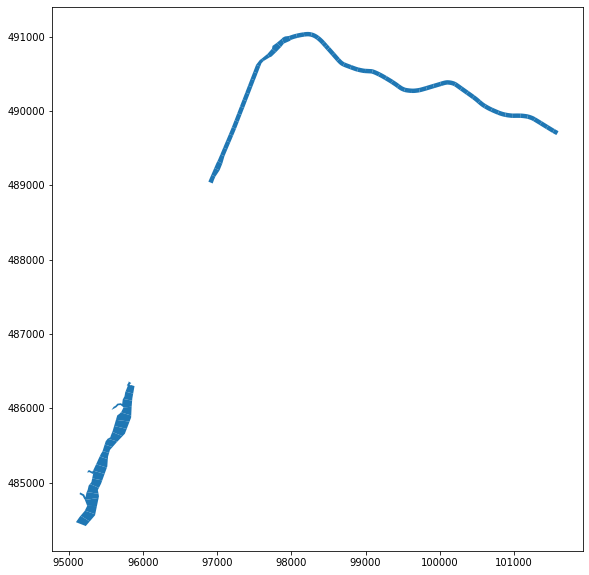

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))
gdf_n200.plot(ax=ax)